<div class="alert alert-block alert-info" style="margin-top: 20px">
<h1>LEVEL BASED PERSONA </h1>
<h3>Simple Segmentation &amp; Rule Based Classification</h3>
<hr />
<h2>Project Purpose &amp; Steps</h2>
<ul>
<li>Thinking about the concept of <strong>persona</strong>.</li>
<li>To be able to define new customers according to the <strong>levels</strong>.</li>
<li>Simply segment new customer definitions using the <strong>qcut function.</strong></li>
<li>When a new customer arrives, classify them according to segments. </li>

</ul>
<hr />
<p>Our goal is to make groupings for customers that exist individually.</p>
<p>Then it is to segment these groups.</p>
<p>Finally, it is trying to determine which of these segments a new customer belongs to.</p>
</div>

<p>What should be obtained before and after the output will be as follows</p>

<pre><code>################# Before #####################
#
# country device gender age  price
# USA     and    M      15   61550
# BRA     and    M      19   45392
# DEU     iOS    F      16   41602
# USA     and    F      17   40004
#                M      23   39802

################# After #####################
#
#   customers_level_based      price groups
# 0        USA_AND_M_0_18 157120.000      A
# 1        USA_AND_F_0_18 151121.000      A
# 2        BRA_AND_M_0_18 149544.000      A
# 3        USA_IOS_F_0_18 133773.000      A
# 4       USA_AND_F_19_23 133645.000      A
</code></pre>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
users = pd.read_csv("dataset/users.csv")
purchases = pd.read_csv("dataset/purchases.csv")

In [3]:
print("Users shape:", users.shape)
print("Purchases shape:", purchases.shape)

Users shape: (10000, 6)
Purchases shape: (9006, 3)


In [4]:
users.head()

,uid,reg_date,device,gender,country,age
0,54030035,2017-06-29T00:00:00Z,and,M,USA,19
1,72574201,2018-03-05T00:00:00Z,iOS,F,TUR,22
2,64187558,2016-02-07T00:00:00Z,iOS,M,USA,16
3,92513925,2017-05-25T00:00:00Z,and,M,BRA,41
4,99231338,2017-03-26T00:00:00Z,iOS,M,FRA,59


In [5]:
purchases.head()

,date,uid,price
0,2017-07-10,41195147,499
1,2017-07-15,41195147,499
2,2017-11-12,41195147,599
3,2017-09-26,91591874,299
4,2017-12-01,91591874,599


### Unique Control

In [6]:
# Unique or not?
def is_unique(col):
    if col.shape[0] == col.nunique():
        print("It is unique!")
    else:
        print("Multipled feature")
        print("Total Size:", col.shape[0])
        print("Unique Size:", col.nunique())

In [7]:
is_unique(users.uid)

It is unique!


In [8]:
is_unique(purchases.uid)

Multipled feature
Total Size: 9006
Unique Size: 1322


In [9]:
# There are 10000 users, the number of purchases is 9006, so not every user has made a purchase.
# There are 1322 unique uids against 9006 lines, so a single user has made more than one purchase. 

### How many purchases has each user made? 

In [10]:
purchases["uid"].value_counts()

41217161    28
67972857    28
82914310    26
44628001    25
83611817    25
            ..
12156579     1
79941469     1
11668937     1
28088851     1
83947073     1
Name: uid, Length: 1322, dtype: int64

### Left join

In [11]:
df = purchases.merge(users, how="left", on="uid")
df.shape

(9006, 8)

In [12]:
is_unique(df.uid)

Multipled feature
Total Size: 9006
Unique Size: 1322


In [13]:
df.head()

,date,uid,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,499,2017-06-26T00:00:00Z,and,M,BRA,17
1,2017-07-15,41195147,499,2017-06-26T00:00:00Z,and,M,BRA,17
2,2017-11-12,41195147,599,2017-06-26T00:00:00Z,and,M,BRA,17
3,2017-09-26,91591874,299,2017-01-05T00:00:00Z,and,M,TUR,17
4,2017-12-01,91591874,599,2017-01-05T00:00:00Z,and,M,TUR,17


### It is desired to focus on each user.

In [14]:
df = users.merge(purchases, how="left", on="uid")

In [15]:
df.head()

,uid,reg_date,device,gender,country,age,date,price
0,54030035,2017-06-29T00:00:00Z,and,M,USA,19,NaN,NaN
1,72574201,2018-03-05T00:00:00Z,iOS,F,TUR,22,NaN,NaN
2,64187558,2016-02-07T00:00:00Z,iOS,M,USA,16,NaN,NaN
3,92513925,2017-05-25T00:00:00Z,and,M,BRA,41,2017-10-20,499.0
4,92513925,2017-05-25T00:00:00Z,and,M,BRA,41,2017-05-29,299.0


In [16]:
df["uid"].nunique()

10000

In [17]:
# random user selection
df[df["uid"]  == 41195147]

,uid,reg_date,device,gender,country,age,date,price
17659,41195147,2017-06-26T00:00:00Z,and,M,BRA,17,2017-07-10,499.0
17660,41195147,2017-06-26T00:00:00Z,and,M,BRA,17,2017-07-15,499.0
17661,41195147,2017-06-26T00:00:00Z,and,M,BRA,17,2017-11-12,599.0


<div class="alert alert-warning" role="alert">
<p>Multiplexed data makes analysis difficult. </p>
<p>What needs to be done is to singularize this data set for each user.</p>
<p>While date and price change, the other variables are fixed variables.</p>
<ul>
<li>date -&gt; getting max for last purchases date</li>
<li>price -&gt; getting mean for average spending per user,</li>
<li>price -&gt; getting count for total amount of transactions </li>

</ul>
<p>But we need to check if the device is fixed or changed. </p>

</div>

In [18]:
df.groupby(["uid", "device"]).agg({"device":"nunique"})

,,device
uid,device,
11116091,and,1
11119626,and,1
11153046,iOS,1
11158549,and,1
11160187,and,1
...,...,...
99975039,and,1
99980066,iOS,1
99982660,and,1


In [19]:
a = df.groupby(["uid", "device"]).agg({"device":"nunique"})
a[a["device"] > 1]

,,device
uid,device,


There are no multiplexed data 

### Singularization 

In [20]:
agg_df = df.groupby("uid").agg({"date":"max", 
                       "price":["mean","count"]})

In [21]:
agg_df.head()

date  price      
                 max   mean count
uid                              
11116091         NaN    NaN     0
11119626         NaN    NaN     0
11153046         NaN    NaN     0
11158549  2018-03-16  459.0     5
11160187         NaN    NaN     0

### Hierarchical index

In [22]:
agg_df.columns

MultiIndex([( 'date',   'max'),
            ('price',  'mean'),
            ('price', 'count')],
           )

In [23]:
agg_df.reset_index(inplace=True)

In [24]:
agg_df.head()

uid        date  price      
                    max   mean count
0  11116091         NaN    NaN     0
1  11119626         NaN    NaN     0
2  11153046         NaN    NaN     0
3  11158549  2018-03-16  459.0     5
4  11160187         NaN    NaN     0

In [25]:
agg_df.columns

MultiIndex([(  'uid',      ''),
            ( 'date',   'max'),
            ('price',  'mean'),
            ('price', 'count')],
           )

In [26]:
[col[0] + "_" + col[1] if col[1] else col[0] for col in agg_df.columns]

['uid', 'date_max', 'price_mean', 'price_count']

In [27]:
agg_df.columns = [col[0] + "_" + col[1] if col[1] else col[0] for col in agg_df.columns]

In [28]:
agg_df.head()

,uid,date_max,price_mean,price_count
0,11116091,NaN,NaN,0
1,11119626,NaN,NaN,0
2,11153046,NaN,NaN,0
3,11158549,2018-03-16,459.0,5
4,11160187,NaN,NaN,0


### Combining two tables for analysis 

In [29]:
all_data = users.merge(agg_df, how="left", on="uid")

In [30]:
all_data.head()

,uid,reg_date,device,gender,country,age,date_max,price_mean,price_count
0,54030035,2017-06-29T00:00:00Z,and,M,USA,19,NaN,NaN,0
1,72574201,2018-03-05T00:00:00Z,iOS,F,TUR,22,NaN,NaN,0
2,64187558,2016-02-07T00:00:00Z,iOS,M,USA,16,NaN,NaN,0
3,92513925,2017-05-25T00:00:00Z,and,M,BRA,41,2018-03-26,424.0,4
4,99231338,2017-03-26T00:00:00Z,iOS,M,FRA,59,NaN,NaN,0


In [31]:
# Tekilleşti mi?
is_unique(all_data.uid)

It is unique!


# Level Based Persona

In [32]:
users = pd.read_csv("dataset/users.csv")
purchases = pd.read_csv("dataset/purchases.csv")

In [33]:
print("Users shape:", users.shape)
print("Purchases shape:", purchases.shape)

Users shape: (10000, 6)
Purchases shape: (9006, 3)


<div class="alert alert-block alert-info" style="margin-top: 20px">
1. Read the users and purchases data sets and merge the data sets according to the "uid" variable with inner join.
</div>   

In [34]:
df = users.merge(purchases, how="inner", on="uid")
df.head()

,uid,reg_date,device,gender,country,age,date,price
0,92513925,2017-05-25T00:00:00Z,and,M,BRA,41,2017-10-20,499
1,92513925,2017-05-25T00:00:00Z,and,M,BRA,41,2017-05-29,299
2,92513925,2017-05-25T00:00:00Z,and,M,BRA,41,2017-08-23,599
3,92513925,2017-05-25T00:00:00Z,and,M,BRA,41,2018-03-26,299
4,16377492,2016-10-16T00:00:00Z,and,M,BRA,20,2018-03-17,199


In [35]:
df.shape

(9006, 8)

<div class="alert alert-block alert-info" style="margin-top: 20px">
2. What are the total earnings in country, device, gender, age breakdown?
</div>

In [36]:
df.groupby(["country", "device", "gender", "age"]).agg({"price": "sum"}).head()

price
country device gender age       
BRA     and    F      15   33824
                      16   31619
                      17   20352
                      18   20047
                      19   21352

<div class="alert alert-block alert-info" style="margin-top: 20px">
<p>3. To see the output better, apply the <code>sort_values</code> method to the code in descending order, according to price.</p>
</div>    

In [37]:
agg_df = df.groupby(["country", "device", "gender", "age"]).agg({"price":"sum"}).sort_values(by="price", ascending=False)
agg_df.head()

price
country device gender age       
USA     and    M      15   61550
BRA     and    M      19   45392
DEU     iOS    F      16   41602
USA     and    F      17   40004
               M      23   39802

<div class="alert alert-block alert-info" style="margin-top: 20px">
4. Convert agg_df's indexes to variable name.
</div>    

In [38]:
agg_df.reset_index(inplace=True)
agg_df.head()

,country,device,gender,age,price
0,USA,and,M,15,61550
1,BRA,and,M,19,45392
2,DEU,iOS,F,16,41602
3,USA,and,F,17,40004
4,USA,and,M,23,39802


<div class="alert alert-block alert-info" style="margin-top: 20px">
5. Convert age variable to categorical variable and add it to <code>agg_df</code> with the name <code>age_cat</code>.
</div>    

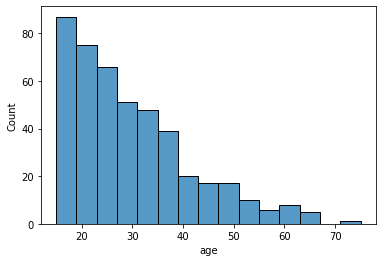

In [39]:
sns.histplot(agg_df["age"]);

In [40]:
bins = [0, 18, 23, 30, 40, agg_df["AGE"].max()]
labels = ['0_18', '19_23', '24_30', '31_40', '41_' + str(agg_df["AGE"].max())]
agg_df["agg_cat"] = pd.cut(agg_df["age"], bins, labels=labels)
agg_df.head()

,country,device,gender,age,price,agg_cat
0,USA,and,M,15,61550,0_18
1,BRA,and,M,19,45392,19_23
2,DEU,iOS,F,16,41602,0_18
3,USA,and,F,17,40004,0_18
4,USA,and,M,23,39802,19_23


<div class="alert alert-block alert-info" style="margin-top: 20px">
6. Define new level based customers and add them to the data set as variables.
</div>    

In [41]:
agg_df["customers_level_based"] = [row[0] + "_" + row[1].upper() + "_" + row[2] + "_" + row[5] for row in agg_df.values]
agg_df.head()

,country,device,gender,age,price,agg_cat,customers_level_based
0,USA,and,M,15,61550,0_18,USA_AND_M_0_18
1,BRA,and,M,19,45392,19_23,BRA_AND_M_19_23
2,DEU,iOS,F,16,41602,0_18,DEU_IOS_F_0_18
3,USA,and,F,17,40004,0_18,USA_AND_F_0_18
4,USA,and,M,23,39802,19_23,USA_AND_M_19_23


# Final Table

In [42]:
agg_df = agg_df[["customers_level_based", "price"]]
agg_df.head()

,customers_level_based,price
0,USA_AND_M_0_18,61550
1,BRA_AND_M_19_23,45392
2,DEU_IOS_F_0_18,41602
3,USA_AND_F_0_18,40004
4,USA_AND_M_19_23,39802


<div class="alert alert-block alert-info" style="margin-top: 20px">
    7. Segment new customers according to price, add them to agg_df with the <code>segment</code> naming.
</div>    

In [43]:
agg_df["segment"] = pd.qcut(agg_df["price"], 4, labels=["D", "C", "B", "A"])
agg_df.head()

,customers_level_based,price,segment
0,USA_AND_M_0_18,61550,A
1,BRA_AND_M_19_23,45392,A
2,DEU_IOS_F_0_18,41602,A
3,USA_AND_F_0_18,40004,A
4,USA_AND_M_19_23,39802,A


<div class="alert alert-block alert-info" style="margin-top: 20px">
    8. Describe the segments.
</div>    

In [44]:
agg_df.groupby("segment").agg({"price": ["mean","count","sum"]}).sort_values("segment", ascending=False)

price               
                 mean count      sum
segment                             
A        20080.150442   113  2269057
B         7447.812500   112   834155
C         3675.504505   111   407981
D         1335.096491   114   152201

## New users segment checking

<div class="alert alert-block alert-info" style="margin-top: 20px">
    9. In what segment is a <strong>42-year-old Turkish woman using IOS?</strong>
</div>    

In [50]:
new_user = "TUR_IOS_F_41_75"
agg_df[agg_df["customers_level_based"] == new_user]

,customers_level_based,price,segment
377,TUR_IOS_F_41_75,1596,D


In [47]:
users[(users["country"]=="TUR") & (users["device"] == "iOS") & (users["gender"] == "F") & (users["age"] == 42) ]

,uid,reg_date,device,gender,country,age
